In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shutil
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Load dataset
root = '../data/'
path = 'ml_features_subset.csv'
df = pd.read_csv(os.path.join(root,path))
df["date"] = pd.to_datetime(df["date"])
df.set_index('date', inplace=True)
df.dropna(inplace=True)
df

,spike_30,past_spikes_30,wind_speed,precipitation,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,,,
2018-01-01 01:00:00,0,2.0,7.127636,0.0,31.102500,0.0,1.527919e+06,10950.736579,1,1,0,0,1.083770
2018-01-01 02:00:00,0,2.0,8.209263,0.0,31.252500,0.0,1.514983e+06,10831.041829,1,2,0,0,0.857405
2018-01-01 03:00:00,0,2.0,9.832680,0.0,31.052501,0.0,1.513766e+06,10264.167962,1,3,0,0,0.824815
2018-01-01 04:00:00,0,2.0,9.028754,0.0,30.902500,0.0,1.521223e+06,10335.796294,1,4,0,0,0.825660
2018-01-01 05:00:00,0,2.0,9.085988,0.0,31.252500,0.0,1.535811e+06,10329.139457,1,5,0,0,0.814085
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0,0.0,8.854829,0.0,7.552501,0.0,6.773428e+05,1400.551985,12,19,0,0,0.968972
2021-12-31 20:00:00,0,0.0,8.225035,0.0,8.102500,0.0,6.541598e+05,990.203456,12,20,0,0,0.934816
2021-12-31 21:00:00,0,0.0,7.993298,0.0,8.352500,0.0,6.266265e+05,1056.321235,12,21,0,0,0.784590


In [42]:
target_col = 'spike_30'
feature_cols = ['past_spikes_30', 'wind_speed', 'precipitation', 'hdd', 
                'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']
sequence_len = 48

# Create a shifted dataset so that we forecast 48h-ahead
X = []
y = []

for i in range(len(df) - sequence_len):
    X_temp = df[feature_cols].iloc[i:i + sequence_len].values
    y_temp = df[target_col].iloc[i + sequence_len]
    
    X.append(X_temp)
    y.append(y_temp)

X = np.array(X)
y = np.array(y)

In [43]:
def lstm_model(dataset, feature_cols, target_col, train_size, sequence_len=48, lstm_units=50, dropout=0.2, dense_units=25, epochs=30, batch_size=32):

    
    def build_lstm_model(sequence_length, feature_count):
        model = Sequential([
            LSTM(lstm_units, activation='relu', return_sequences=True, input_shape=(sequence_length, feature_count)),
            Dropout(dropout),
            LSTM(lstm_units, activation='relu', return_sequences=False),
            Dropout(dropout),
            Dense(dense_units),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def create_sequences(features, target, sequence_len):
        X, y = [], []
        for i in range(len(features) - sequence_len):
            X.append(features[i:i+sequence_len])
            y.append(target[i+sequence_len])
        return np.array(X), np.array(y)
    
    X_data = dataset[feature_cols].values
    y_data = dataset[target_col].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_scaled = scaler.fit_transform(X_data)

    X, y = create_sequences(features_scaled, y_data, sequence_len)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define the LSTM model
    feature_count = len(feature_cols)
    model = build_lstm_model(sequence_len, feature_count)

    # Fit the model
    print('Fitting the model:')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

    return model, history, X_train, X_test, y_train, y_test

In [45]:
# Build LSTM model for first split (train 2018-2020, test 2021)
train_size = 26225
model_1, history_1, X_train_1, X_test_1, y_train_1, y_test_1 = lstm_model(dataset=df,
                                                                          feature_cols=feature_cols,
                                                                          target_col=target_col,
                                                                          train_size=train_size, 
                                                                          sequence_len=48,
                                                                          lstm_units=50, 
                                                                          dropout=0.2, 
                                                                          dense_units=25,
                                                                          epochs=30, 
                                                                          batch_size=32)

C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting the model:
Epoch 1/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9382 - loss: 0.2564 - val_accuracy: 0.9061 - val_loss: 0.2982
Epoch 2/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9491 - loss: 0.1873 - val_accuracy: 0.9061 - val_loss: 0.2846
Epoch 3/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9473 - loss: 85.7615 - val_accuracy: 0.9061 - val_loss: 0.2849
Epoch 4/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9445 - loss: 0.3553 - val_accuracy: 0.9061 - val_loss: 0.2946
Epoch 5/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9474 - loss: 0.1898 - val_accuracy: 0.9061 - val_loss: 0.2931
Epoch 6/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9485 - loss: 0.1949 - val_accuracy: 0.9061 - val_loss: 0.2959
Epoch 7/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9480 - loss: 0.1915 - val_accuracy: 0.9061 - val_loss: 0.2947
Epoch 8/30
820/820 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.94

In [46]:
y_pred_prob = model_1.predict(X_test_1).ravel()
y_pred_prob

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


array([0.018347  , 0.01194804, 0.00891124, ..., 0.03527138, 0.02523109,
       0.01778989], dtype=float32)

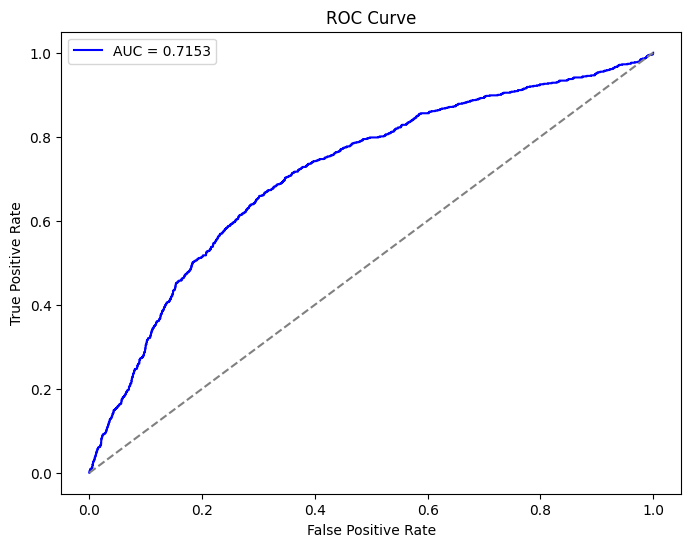

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute AUC
auc = roc_auc_score(y_test_1, y_pred_prob)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_1, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [48]:
# Average Log-Likelihood
p = np.clip(y_pred_prob, 1e-9, 1 - 1e-9)

log_lik_i = y_test_1 * np.log(p) + (1 - y_test_1) * np.log(1 - p)
avg_log_likelihood = np.mean(log_lik_i)

print("Average Log-Likelihood:", avg_log_likelihood)

Average Log-Likelihood: -0.31683784890159994
